In [1]:
from IP import *
import IP
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import skimage
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from skimage.util import random_noise
from skimage.filters import median
%matplotlib inline
from scipy.io import loadmat
import pywt
import pywt.data
import copy

In [2]:
data1 = loadmat('data1.mat')
data2 = loadmat('data2.mat')
data3 = loadmat('data3.mat')

# resizing
imlen = 128
data1 = imresize(data1['image'],(imlen,imlen),anti_aliasing=True)
data2 = imresize(data2['image'],(imlen,imlen),anti_aliasing=True)
data3 = imresize(data3['image'],(imlen,imlen),anti_aliasing=True)

# converting them to 0-255 uint8 images
data1_resized= data1-data1.min()
data1_resized= (data1_resized/data1_resized.max()*255).astype("int")
data2_resized= data2-data2.min()
data2_resized= (data2_resized/data2_resized.max()*255).astype("int")
data3_resized= data3-data3.min()
data3_resized= (data3_resized/data3_resized.max()*255).astype("int")

# Wavelet-based Speckle Filter 
[Gupta et al., 2004]

In [3]:
def logTran(I,c):
    I2 = c*np.log10(1+I)
    I2=I2-I2.min()
    I2=(I2/I2.max()*255).astype("int")
    return I2

In [4]:
def expTran(I,c):
    I2 = 10**(I/float(c))-1
    I2=I2-I2.min()
    I2=(I2/I2.max()*255).astype("int")
    return I2

In [5]:
def wavelet_filt(image, filter_='db8'):

    coeffs2 = pywt.wavedec2(logTran(image,100),filter_,level=4)
    HH1 = coeffs2[-1][-1] # first [-1] selects level 1, second [-1] chooses HH1
    sigma2 = (np.median(abs(HH1))/(0.6745))**2
    K = [np.sqrt(np.log10(coeffs2[-k][0].shape[0])) for k in range(1,5)] # K[0] is for level 1, K[1] for level 2 etc.

    thresholded_coeffs2 = [coeffs2[0]]

    for level_idx in range(1,5): # coeffs2[0] is the appx, which we dont need for now. loop 1 through 4 for detail coeffs in the associated levels
        level_tuple=[]
        for subband_idx in range(3):
            subband = coeffs2[level_idx][subband_idx]
            sigma2_y = np.sum(subband*subband)/float(subband.shape[0]**2)
            if sigma2_y>sigma2:
                sigma_x = np.sqrt(sigma2_y-sigma2)
                if sigma_x**2 >sigma2:
                    T_N = K[level_idx-1]*(sigma2/sigma_x)
                else:
                    T_N = np.max(subband)
            else: 
                T_N = np.max(subband)
            subband_out = pywt.threshold(subband, T_N, mode='soft', substitute=0)
            level_tuple.append(subband_out)
        thresholded_coeffs2.append(tuple(level_tuple))

    out = pywt.waverec2(thresholded_coeffs2,filter_)

    return expTran(out,100),out

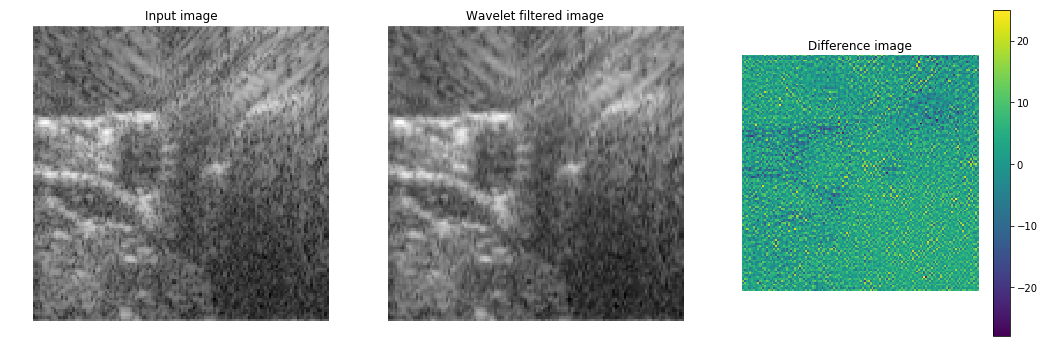

In [6]:
output_wavelet,out= wavelet_filt(data2_resized)
plt.figure(figsize=(18, 6))
plt.subplot(1,3,1)
imshow(data2_resized,cmap='gray')
plt.title("Input image");plt.axis("Off")
plt.subplot(1,3,2)
imshow(output_wavelet,cmap='gray')
plt.title("Wavelet filtered image");plt.axis("Off")
plt.subplot(1,3,3)
I_diff=data2_resized-output_wavelet
imshow(I_diff,vmin=I_diff.min(),vmax=I_diff.max());
plt.title("Difference image");plt.colorbar()
plt.axis("off")
plt.savefig('input_output.eps', format='eps')

# Homomorphic Weiner Filter

In [8]:
def homomorphicWienerFilter(image, B=1e-7,mysize=None):
    from scipy.signal import wiener
    logTransformed = np.log(image+B)
    filtered = wiener(logTransformed,mysize)
    I2 = np.exp(filtered)
    I2=I2-I2.min()
    I2=(I2/I2.max()*255).astype("int")
    return I2

# Geometric Filter (GF)

In [9]:
# this function checks if a 0 should be converted into a 1 according
# to the 8-hull template patterns

def check_hull8_pattern(block,mode='all'):
    pattern1 = np.array([[1,0,0],[1,0,0],[1,1,0]])
    pattern2 = np.array([[0,0,0],[1,0,0],[1,1,1]])
    pattern3 = np.array([[0,0,0],[0,0,1],[1,1,1]])
    pattern4 = np.array([[0,0,1],[0,0,1],[0,1,1]])
    patterns_a = [pattern1,pattern2,pattern3,pattern4]
    
    if(mode=='a'):
        for pattern in patterns_a:
            block_temp = block*pattern
            if(np.array_equal(block_temp, pattern)):
                # found match!
                return True
               
    pattern5 = np.array([[1,1,0],[1,0,0],[1,0,0]])
    pattern6 = np.array([[1,1,1],[1,0,0],[0,0,0]])
    pattern7 = np.array([[1,1,1],[0,0,1],[0,0,0]])
    pattern8 = np.array([[0,1,1],[0,0,1],[0,0,1]])
    patterns_b = [pattern5,pattern6,pattern7,pattern8]
    
    if(mode=='b'):
        for pattern in patterns_b:
            block_temp = block*pattern
            if(np.array_equal(block_temp, pattern)):
                # found match!
                return True
    
    patterns_all = patterns_a+patterns_b
    
    if(mode=='all'):
        for pattern in patterns_all:
            block_temp = block*pattern
            if(np.array_equal(block_temp, pattern)):
                # found match!
                return True
    
    # no match found 
    return False

In [10]:
# implements 8-hull algorithm

def hull8(I,mode='all'):
    output = np.zeros((I.shape))
    output[0:1,:] = I[0,:]
    output[-1:,:] = I[-1,:]
    output[:,0:1] = I[:,0:1]
    output[:,-1:] = I[:,-1:]
    for row in range(1,I.shape[0]-1):
        for col in range(1,I.shape[1]-1):
            # if center pixel is already 1, we don't care
            if(I[row,col] == 0): 
                neighborhood_block = I[row-1:row+2,col-1:col+2]
                if (check_hull8_pattern(neighborhood_block,mode)):
                    output[row,col] = 1
            else:
                output[row,col] = 1
    return output

In [11]:
# converts 0's to 1's and vice versa. 
# Wonder if there was a better way though.

def complement_mat(i):
    return 1*(i<0.5)

In [12]:
# implements the complimentary hull algorithm
def complimentary_hull(I):
    I1 = hull8(I,'a')
    I1 = complement_mat(I1)
    I1 = hull8(I1,'b')
    I1 = complement_mat(I1)
    return I1

In [13]:
# from a line of pixels, generates a vertical pixel grid
def pixelrow2vertgrid(pixel_row):
    vertical_grid = np.zeros((256,len(pixel_row)),int)
    for idx,intensity in enumerate(pixel_row):
        vertical_grid[255-intensity:,idx] = 1
    return vertical_grid

In [14]:
# from a vertical pixel grid, goes back to line of pixels
def vertgrid2pixelrow(vertical_grid):
    return np.sum(vertical_grid,axis=0)-1

In [15]:
def GF(I2):
    I = imresize(I2,(64,64),anti_aliasing=True)
    I = I-I.min()
    I = (I/I.max()*255).astype("int");
    #E-W direction
    print('GF step: Beginning E-W direction')
    temp=np.zeros(I.shape,int)
    for row in range(I.shape[0]):
        # generate vertical pixel grid
        vertical_grid=pixelrow2vertgrid(list(I[row,:].\
                                             astype("int")))
        
        # run complimentary hull algorithm on the grid
        comp_output = complimentary_hull(vertical_grid)
        
        # convert updated grid back to a line of pixels
        updated_row = vertgrid2pixelrow(comp_output)
        
        # save the row
        temp[row,:] = updated_row
    
    #N-S direction
    print('GF step: Beginning N-S direction')
    temp2=np.zeros(I.shape,int)
    for col in range(I.shape[1]):
        # same as before
        vertical_grid=pixelrow2vertgrid(list(temp[:,col].\
                                             astype("int")))
        comp_output = complimentary_hull(vertical_grid)
        updated_row = vertgrid2pixelrow(comp_output)
        temp2[:,col] = updated_row  
    
    # SE-NW direction
    print('GF step: Beginning SE-NW direction')
    diags1 = [temp2.diagonal(i) for i in range(temp2.shape[1]-1,\
                                               -temp2.shape[0],-1)]
    
    temp3=np.zeros(I.shape,int)
    for idx, diag in enumerate(diags1):
        # same as before
        vertical_grid=pixelrow2vertgrid(list(np.round(diag).\
                                             astype("int")))
        comp_output = complimentary_hull(vertical_grid)
        updated_row = vertgrid2pixelrow(comp_output)
        if(idx<I.shape[0]):
            i = I.shape[0]-1-idx
            np.fill_diagonal(temp3[:,i:], updated_row)
        else:
            i = idx + 1-I.shape[0]
            np.fill_diagonal(temp3[i:], updated_row)

    # SW-NE direction
    print('GF step: Beginning SW-NE direction')
    diags2 = [temp3[::-1,:].diagonal(i) for i in \
              range(-temp3.shape[0]+1,temp3.shape[1])]
    
    temp4=np.zeros(I.shape,int)
    for idx, diag in enumerate(diags2):
        # same as before
        vertical_grid=pixelrow2vertgrid(list(np.round(diag).\
                                             astype("int")))
        comp_output = complimentary_hull(vertical_grid)
        updated_row = vertgrid2pixelrow(comp_output)
        row_opposite = updated_row[::-1]
        temp4=np.fliplr(temp4)
        if(idx<I.shape[0]):
            i = I.shape[0]-1-idx
            np.fill_diagonal(temp4[:,i:], row_opposite)
        else:
            i = idx + 1-I.shape[0]
            np.fill_diagonal(temp4[i:], row_opposite)
        temp4=np.fliplr(temp4)
    output = imresize(temp4,(I2.shape[0],I2.shape[0]),anti_aliasing=True)
    output = output-output.min()
    output = (output/output.max()*255).astype("int");
    
    return output

# Adaptive Weighted Median Filter (AWMF)

In [16]:
# this function creates a distance matrix where each entry holds the
# corresponding pixel location's Eucledian distance from the center pixel
def generate_d(w_len):
    dist_mat = np.zeros((w_len,w_len))
    padding_len = int(np.floor(w_len/2.))
    for i in range(w_len):
        for j in range(w_len):
            dist_mat[i,j]=\
            np.linalg.norm(np.array([i,j])\
                           -np.array([padding_len,padding_len]))
    return dist_mat

In [17]:
# calculate the weight coefficients according to Loupas et al. [1]
def generate_w(w0,c,d,sig2,miu):
    temp_w = w0-(c*d*sig2/miu)
    temp_w[temp_w<0]=0
    return temp_w.round()

In [18]:
# replicates each pixel under the window 'weight' number of times
# to update its prominence in median calculation
def weighted_values(values,weights):
    weighted_list = []
    for i in range(values.shape[0]):
        for j in range(values.shape[1]):
            weighted_list.extend([values[i,j]]*weights[i,j])
    return weighted_list

In [19]:
def AWMF(I,w_len,w0,c,plot_steps=False):
    if(plot_steps):
        IP.plt.figure(figsize=(12,4))
        IP.plt.subplot(1,2,1);IP.plt.title('Input Image')
        IP.imshow(I,cmap='gray')
        print("Shape of input image:"+str(I.shape))
    
    if(w_len % 2 == 0):
        print("Please insert an odd kernel window length.")
        return
    
    #compute number of layers to pad
    padding_len = int(np.floor(w_len/2.))
    
    #initialize padded image with all zeros
    padded_I = np.zeros((I.shape[0]+2*padding_len,I.shape[1]+2*padding_len))
    
    # assign main image to the middle of the padded_image
    padded_I[padding_len:-padding_len,padding_len:-padding_len]=I
    
    #nearest neighbor assignments to the horizontal and vertical padded segments
    padded_I[0:padding_len,padding_len:-padding_len] = I[0,:]
    padded_I[-padding_len:,padding_len:-padding_len] = I[-1,:]
    padded_I[padding_len:-padding_len,0:padding_len] = I[:,0:1]
    padded_I[padding_len:-padding_len,-padding_len:] = I[:,-1:]
    
    #taking care of the four square corners of the padded layers
    padded_I[0:padding_len,0:padding_len] = \
    np.repeat(I[0,0], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[-padding_len:,0:padding_len] = \
    np.repeat(I[-1,0], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[0:padding_len:,-padding_len:] = \
    np.repeat(I[0,-1], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[-padding_len:,-padding_len:] = \
    np.repeat(I[-1,-1], padding_len*padding_len).reshape(padding_len,padding_len)
    
    #initialize filtered image with all zeros
    filtered_I = np.zeros(I.shape)
    
    # compute distance matrix
    distance_mat = generate_d(w_len=w_len)
    
    #scan padded image with a kernel window of w_len*w_len dimension
    for id_r,row in enumerate(range(padding_len,padded_I.shape[0]-padding_len)):
        for id_c,col in enumerate(range(padding_len,padded_I.shape[1]-padding_len)):
            #grab values within kernel window and take median
            values = padded_I[row-padding_len:row+padding_len+1,\
                              col-padding_len:col+padding_len+1]
            
            # adaptively generate each pixel value's weight
            weights = generate_w(w0,c,distance_mat,\
                                 sig2=np.var(values),miu=np.mean(values))
            
            # replicate pixels according to weights
            weighted_values_list = weighted_values(values.astype("int"),\
                                                   weights.astype("int"))
          
            #assign median to filtered image
            filtered_I[id_r,id_c] = np.median(weighted_values_list)
    
    if(plot_steps):
        IP.plt.subplot(1,2,2);
        IP.imshow(filtered_I,cmap='gray');IP.plt.title('AWMF Filtered Image')
        print("Shape of filtered image:"+str(filtered_I.shape))
    return filtered_I

# Directional Median Filter (DMF)

In [20]:
def generate_sticks(w_len):
    padding_len = int(np.floor(w_len/2.))
    
    # horizontal stick
    a = np.zeros((w_len,w_len), int)
    a[padding_len,:]=1
    
    # diagonal stick
    d = np.zeros((w_len,w_len), int)
    np.fill_diagonal(d,1)
    
    # the other diagonal stick
    b=np.flip(d,axis=1)
    
    # vertical stick
    c = np.zeros((w_len,w_len), int)
    c[:,padding_len]=1
    
    return a,b,c,d

In [21]:
def DMF(I,w_len,plot_steps=False):
    if(plot_steps):
        IP.plt.figure(figsize=(12,4))
        IP.plt.subplot(1,2,1);IP.plt.title('Input Image')
        IP.imshow(I,cmap='gray')
        print("Shape of input image:"+str(I.shape))
    
    if(w_len % 2 == 0):
        print("Please insert an odd kernel window length.")
        return
    
    #compute number of layers to pad
    padding_len = int(np.floor(w_len/2.))
    
    #initialize padded image with all zeros
    padded_I = np.zeros((I.shape[0]+2*padding_len,I.shape[1]+2*padding_len))
    
    # assign main image to the middle of the padded_image
    padded_I[padding_len:-padding_len,padding_len:-padding_len]=I
    
    #nearest neighbor assignments to the horizontal and vertical padded segments
    padded_I[0:padding_len,padding_len:-padding_len] = I[0,:]
    padded_I[-padding_len:,padding_len:-padding_len] = I[-1,:]
    padded_I[padding_len:-padding_len,0:padding_len] = I[:,0:1]
    padded_I[padding_len:-padding_len,-padding_len:] = I[:,-1:]
    
    #taking care of the four square corners of the padded layers
    padded_I[0:padding_len,0:padding_len] = \
    np.repeat(I[0,0], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[-padding_len:,0:padding_len] = \
    np.repeat(I[-1,0], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[0:padding_len:,-padding_len:] = \
    np.repeat(I[0,-1], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[-padding_len:,-padding_len:] = \
    np.repeat(I[-1,-1], padding_len*padding_len).reshape(padding_len,padding_len)
    
    # initialize filtered image with all zeros
    filtered_I = np.zeros(I.shape)
    
    # get the four sticks
    a,b,c,d = generate_sticks(w_len) 
    
    #scan padded image with a kernel window of w_len*w_len dimension
    for id_r,row in enumerate(range(padding_len,padded_I.shape[0]-padding_len)):
        for id_c,col in enumerate(range(padding_len,padded_I.shape[1]-padding_len)):
            #grab values within kernel window and take median
            values = padded_I[row-padding_len:row+padding_len+1,\
                              col-padding_len:col+padding_len+1].astype("int")
            
            # consider the values lying along the sticks
            stick_a = values[values*a>0]
            stick_b = values[values*b>0]
            stick_c = values[values*c>0]
            stick_d = values[values*d>0]
            
            # compute median along each stick orientation
            median_list = [np.median(stick_a),\
                           np.median(stick_b),np.median(stick_c),\
                           np.median(stick_d)]
          
            #assign max median to filtered image
            filtered_I[id_r,id_c] = max(median_list)
    
    if(plot_steps):
        IP.plt.subplot(1,2,2);
        IP.imshow(filtered_I,cmap='gray')
        IP.plt.title('Directional Median Filtered Image')
        print("Shape of filtered image:"+str(filtered_I.shape))
    return filtered_I

# Aggressive Region Growing Filter (ARGF)

In [22]:
def ARGF(I,w_len,a=2.,b=19.5,c=0.3,d=0.004,k=0.5,S_min=49,plot_steps=False):
    if(plot_steps):
        IP.plt.figure(figsize=(18,4))
        IP.plt.subplot(1,3,1);IP.plt.title('Input Image')
        IP.imshow(I,cmap='gray')
        print("Shape of input image:"+str(I.shape))
    
    if(w_len % 2 == 0):
        print("Please insert an odd kernel window length.")
        return
    
    #compute number of layers to pad
    padding_len = int(np.floor(w_len/2.))
    
    #initialize padded image with all zeros
    padded_I = np.zeros((I.shape[0]+2*padding_len,I.shape[1]+2*padding_len))
    
    # assign main image to the middle of the padded_image
    padded_I[padding_len:-padding_len,padding_len:-padding_len]=I
    
    #nearest neighbor assignments to the horizontal and vertical padded segments
    padded_I[0:padding_len,padding_len:-padding_len] = I[0,:]
    padded_I[-padding_len:,padding_len:-padding_len] = I[-1,:]
    padded_I[padding_len:-padding_len,0:padding_len] = I[:,0:1]
    padded_I[padding_len:-padding_len,-padding_len:] = I[:,-1:]
    
    #taking care of the four square corners of the padded layers
    padded_I[0:padding_len,0:padding_len] = \
    np.repeat(I[0,0], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[-padding_len:,0:padding_len] = \
    np.repeat(I[-1,0], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[0:padding_len:,-padding_len:] = \
    np.repeat(I[0,-1], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[-padding_len:,-padding_len:] = \
    np.repeat(I[-1,-1], padding_len*padding_len).reshape(padding_len,padding_len)

    if(plot_steps):
        IP.plt.subplot(1,3,2);
        IP.imshow(padded_I,cmap='gray');IP.plt.title('Padded Image')
        print("Shape of padded image:"+str(padded_I.shape))
    
    #initialize filtered image with all zeros
    filtered_I = np.zeros(I.shape) 
    
    #scan padded image with a kernel window of w_len*w_len dimension
    for id_r,row in enumerate(range(padding_len,padded_I.shape[0]-padding_len)):
        for id_c,col in enumerate(range(padding_len,padded_I.shape[1]-padding_len)):
            # grab values within kernel window and take median
            values = padded_I[row-padding_len:row+padding_len+1,\
                              col-padding_len:col+padding_len+1]
            
            # region contraction phase
            hij = np.var(values)/np.mean(values)
            h0wd = (a*values.size)/(b+values.size)
            sig0wd = c+k*np.exp(-1*d*(values.size))
            temp_len = padding_len
            
            # keep contracting until condition is violated
            while(hij>(h0wd+sig0wd) and values.size>S_min):
                temp_len = temp_len-1
                values = padded_I[row-temp_len:row+temp_len+1,\
                                  col-temp_len:col+temp_len+1]
                hij = np.var(values)/np.mean(values)
                h0wd = (a*values.size)/(b+values.size)
                sig0wd = c+k*np.exp(-1*d*(values.size))

            # region growth phase
            hij = np.var(values)/np.mean(values)
            h0wd = (a*values.size)/(b+values.size)
            sig0wd = c+k*np.exp(-1*d*(values.size))
            hij_old = hij
            temp_len2 = temp_len
            
            # keep growing until condition is violated
            while(hij<=(h0wd+sig0wd) and values.size<w_len**2 \
                  and np.abs(hij-hij_old)<sig0wd):
                hij_old = hij
                temp_len2 = temp_len2+1
                values = padded_I[row-temp_len2:row+temp_len2+1,\
                                  col-temp_len2:col+temp_len2+1]
                hij = np.var(values)/np.mean(values)
                h0wd = (a*values.size)/(b+values.size)
                sig0wd = c+k*np.exp(-1*d*(values.size))
          
            #assign mean or median to filtered image
            if(values.size > w_len**2):
                filtered_I[id_r,id_c] = np.mean(values)
            else:
                filtered_I[id_r,id_c] = np.median(values)
    
    if(plot_steps):
        IP.plt.subplot(1,3,3);
        IP.imshow(filtered_I,cmap='gray');IP.plt.title('Filtered Image')
        print("Shape of filtered image:"+str(filtered_I.shape))
    return filtered_I

# Compiling Outputs

In [23]:
image_list = [data1_resized, data2_resized, data3_resized] 
# output_collection = {1:[output_wavelet,output_weiner, output_DMF, output_GF,output_AWMF,output_ARGF,output_med2D], 2:[], 3:[]} 
output_collection = {1:[], 2:[], 3:[]} 

for idx, im in enumerate(image_list):
    print("Applying Wavelet to data"+str(idx+1))
    output_wavelet,_ = wavelet_filt(im)
    output_collection[idx+1].append(output_wavelet)
    
    print("Applying Weiner to data"+str(idx+1))
    output_weiner = homomorphicWienerFilter(im)
    output_collection[idx+1].append(output_weiner)
    
    print("Applying DMF to data"+str(idx+1))
    output_DMF = DMF(im,w_len=5,plot_steps=False)
    output_collection[idx+1].append(output_DMF)
    
    print("Applying GF to data"+str(idx+1))
    output_GF = GF(im)
    output_collection[idx+1].append(output_GF)
    
    print("Applying AWMF to data"+str(idx+1))
    output_AWMF = AWMF(im,w_len=5,w0=5,c=0.25,plot_steps=False)
    output_collection[idx+1].append(output_AWMF)
    
    print("Applying ARGF to data"+str(idx+1))
    output_ARGF = ARGF(im,w_len=5,a=2.,b=19.5,c=0.3,\
                     d=0.004,k=0.5,S_min=9,plot_steps=False)
    output_collection[idx+1].append(output_ARGF)
    
    print("Applying Med2D to data"+str(idx+1))
    output_med2D = medfil2d(im,5)
    output_collection[idx+1].append(output_med2D)
    

Applying Wavelet to data1
Applying Weiner to data1
Applying DMF to data1
Applying GF to data1
GF step: Beginning E-W direction
GF step: Beginning N-S direction
GF step: Beginning SE-NW direction
GF step: Beginning SW-NE direction
Applying AWMF to data1
Applying ARGF to data1
Applying Med2D to data1
Applying Wavelet to data2
Applying Weiner to data2
Applying DMF to data2
Applying GF to data2
GF step: Beginning E-W direction
GF step: Beginning N-S direction
GF step: Beginning SE-NW direction
GF step: Beginning SW-NE direction
Applying AWMF to data2
Applying ARGF to data2
Applying Med2D to data2
Applying Wavelet to data3
Applying Weiner to data3
Applying DMF to data3
Applying GF to data3
GF step: Beginning E-W direction
GF step: Beginning N-S direction
GF step: Beginning SE-NW direction
GF step: Beginning SW-NE direction
Applying AWMF to data3
Applying ARGF to data3
Applying Med2D to data3


# Performance Metrics

In [24]:
def edgeScore(s1,s2,roi):
    import skimage as sio
    from skimage.filters import laplace
    
    #Convert to grayscale
    s1 = IP.rgb2gray(s1);
    s2 = IP.rgb2gray(s2);
    #Crop the region of interest
    s1ROI = s1[roi[0]:roi[2],roi[1]:roi[3]];
    s2ROI = s2[roi[0]:roi[2],roi[1]:roi[3]];
    
    s1filt = laplace(s1ROI)
    s2filt = laplace(s2ROI)
    s1mean = np.mean(s1filt)
    s2mean = np.mean(s2filt)
    
    s1diff = s1filt - s1mean
    s2diff = s2filt - s2mean
    
    alpha = np.dot(s1diff.ravel(),s2diff.ravel())/np.sqrt(np.dot(np.dot(s1diff.ravel(),s1diff.ravel()),np.dot(s2diff.ravel(),s2diff.ravel())))
    return alpha

In [25]:
def correlationCoef(s1,s2,roi):
    import skimage as sio
    #Convert to grayscale
    s1 = IP.rgb2gray(s1);
    s2 = IP.rgb2gray(s2);
    #Crop the region of interest
    s1ROI = s1[roi[0]:roi[2],roi[1]:roi[3]];
    s2ROI = s2[roi[0]:roi[2],roi[1]:roi[3]];
    s1mean = np.mean(s1ROI)
    s2mean = np.mean(s2ROI)
    s1diff = s1ROI - s1mean
    s2diff = s2ROI - s2mean
    alpha = np.dot(s1diff.ravel(),s2diff.ravel())/np.sqrt(np.dot(np.dot(s1diff.ravel(),s1diff.ravel()),np.dot(s2diff.ravel(),s2diff.ravel())))
    return alpha

In [26]:
def signal_to_mse(original,denoised):
    signal = np.sum(original**2)
    error  = np.sum((original-denoised)**2)
    return 10 * np.log10(signal/error)

In [27]:
list_algo = ['Wavelet','Weiner','DMF','GF','AWMF','ARGF','Med2D']

for data_id,list_of_outputs in output_collection.items():
    print("======")
    print("Data "+str(data_id))
    print("======")
    for algo_id, output in enumerate(list_of_outputs):
        print(list_algo[algo_id])
        output = imresize(output,(imlen,imlen))
        output = output-output.min()
        output = (output/output.max()*255).astype("int")
        rho = correlationCoef(image_list[data_id-1],output,(0,0,imlen,imlen))
        edge = edgeScore(image_list[data_id-1],output,(0,0,imlen,imlen))
        s2mse = signal_to_mse(image_list[data_id-1],output)
        
        print("rho: "+str(rho))
        print("edge: "+str(edge))
        print("s2mse: "+str(s2mse))
        print(" ")
    print(" ") 

Data 1
Wavelet
rho: 0.9821522665885694
edge: 0.79655467065576
s2mse: 21.590061798048605
 
Weiner
rho: 0.9235106848028022
edge: 0.07248316309528205
s2mse: 16.259133322080604
 
DMF
rho: 0.9151206479217995
edge: 0.3267510682401568
s2mse: 14.445484989573687
 
GF
rho: 0.8962484718746435
edge: 0.2793000323368436
s2mse: 14.358974750183233
 
AWMF
rho: 0.8995484704894761
edge: 0.18533920678222554
s2mse: 15.960874208163268
 
ARGF
rho: 0.9104121364041565
edge: 0.07619411106345658
s2mse: 15.468437448399598
 
Med2D
rho: 0.8778817802785472
edge: 0.019042314382895564
s2mse: 12.97285695943684
 
 
Data 2
Wavelet
rho: 0.9849362002877363
edge: 0.7817228136662273
s2mse: 24.325512941951963
 
Weiner
rho: 0.9435845101387124
edge: 0.13661198399770302
s2mse: 18.53148188134285
 
DMF
rho: 0.9335537995013615
edge: 0.32412537375443073
s2mse: 15.945664070804767
 
GF
rho: 0.9169441646540623
edge: 0.2890520743801748
s2mse: 14.89959679002017
 
AWMF
rho: 0.9182002376518309
edge: 0.15174649072428617
s2mse: 13.9364331930

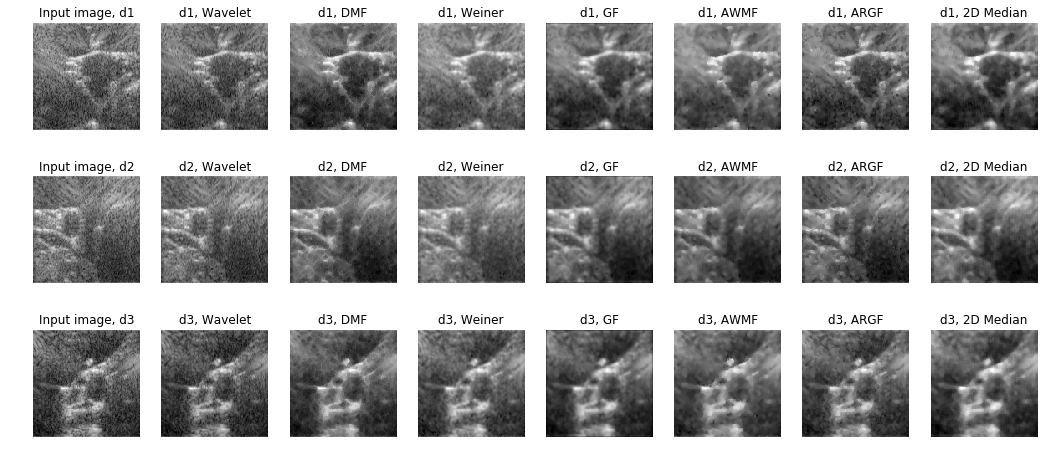

In [28]:
# plotting outputs
IP.plt.figure(figsize=(18,8))

for idx, im in enumerate(image_list):
    IP.plt.subplot(3,8,8*idx+1)
    IP.imshow(im,cmap='gray')
    IP.plt.title('Input image, d'+str(idx+1));plt.axis("Off")
    
    IP.plt.subplot(3,8,8*idx+2)
    IP.imshow(output_collection[idx+1][0],cmap='gray')
    IP.plt.title('d'+str(idx+1)+', Wavelet');plt.axis("Off")
    
    IP.plt.subplot(3,8,8*idx+3)
    IP.imshow(output_collection[idx+1][2],cmap='gray')
    IP.plt.title('d'+str(idx+1)+', DMF');plt.axis("Off")
    
    IP.plt.subplot(3,8,8*idx+4)
    IP.imshow(output_collection[idx+1][1],cmap='gray')
    IP.plt.title('d'+str(idx+1)+', Weiner');plt.axis("Off")
    
    IP.plt.subplot(3,8,8*idx+5)
    IP.imshow(output_collection[idx+1][3],cmap='gray')
    IP.plt.title('d'+str(idx+1)+', GF');plt.axis("Off")
    
    IP.plt.subplot(3,8,8*idx+6)
    IP.imshow(output_collection[idx+1][4],cmap='gray')
    IP.plt.title('d'+str(idx+1)+', AWMF');plt.axis("Off")
    
    IP.plt.subplot(3,8,8*idx+7)
    IP.imshow(output_collection[idx+1][5],cmap='gray')
    IP.plt.title('d'+str(idx+1)+', ARGF');plt.axis("Off")

    IP.plt.subplot(3,8,8*idx+8)
    IP.imshow(output_collection[idx+1][6],cmap='gray')
    IP.plt.title('d'+str(idx+1)+', 2D Median');plt.axis("Off")
plt.savefig('output_comb.eps', format='eps')